Using whichever tools, libraries or languages you prefer, develop a set of
tools/scripts that can assess the accuracy of each supplier DEM compared to the reference DEM. Important statistical criteria include:

* mean error
* standard deviation
* root mean squared error (RMSE)

Collate the error reports for each of the supplier DEMs into a single spreadsheet for easy comparison, highlighting and DEMs that appear to fail quality assurance, and perhaps why they do?

In [1]:
import warnings
warnings.filterwarnings('ignore')

import glob
import pandas as pd
import numpy as np
import rasterio
from rasterio import warp
from rasterio.plot import show
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

rasterio.__version__

'1.0.13'

test

In [2]:
data_dir = '/Users/robincole/Documents/Data/EODS_Test_Data/supplier_DEMs/'

In [3]:
supplier_DEMs = glob.glob(data_dir + '*')
print(len(supplier_DEMs))
supplier_DEMs[:3]

50


['/Users/robincole/Documents/Data/EODS_Test_Data/supplier_DEMs/dem_58478.tif',
 '/Users/robincole/Documents/Data/EODS_Test_Data/supplier_DEMs/dem_27441.tif',
 '/Users/robincole/Documents/Data/EODS_Test_Data/supplier_DEMs/dem_51298.tif']

write convenience to extract file id

In [4]:
def get_id(file_path : str) -> str:
    """
    Return the image id from the file path string.
    """
    try: 
        return file_path.split('/')[-1].strip('dem_').strip('.tif') 
    except:
        return file_path

In [5]:
get_id(supplier_DEMs[0])

'58478'

## View reference DEM
Use rasterio to view Geotiff

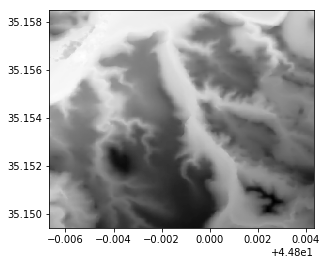

In [6]:
ref_file = 'Reference_DEM.tif'
ref_dem = rasterio.open(ref_file)
show(ref_dem, cmap='Greys');

In [7]:
ref_dem.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -32767.0,
 'width': 547,
 'height': 450,
 'count': 1,
 'crs': CRS({'init': 'epsg:4326'}),
 'transform': Affine(2.0100364035837486e-05, 0.0, 44.79332277978086,
        0.0, -2.0100364035837486e-05, 35.15847148234509)}

So our reference dem is in WGS 84 coordinate frame, and has a shape 450, 547 pixels. 
We can access the array data and generate some stats

In [8]:
array = ref_dem.read(1) # access the pixel data

In [9]:
ref_dem.bounds

BoundingBox(left=44.79332277978086, bottom=35.14942631852897, right=44.80431767890846, top=35.15847148234509)

In [10]:
np.mean(array)

214.4507

Create helper to extract metadata for a file

In [11]:
def get_dem_metadata(file_path):
    """
    Return a dict of info about a dem object.
    """
    with rasterio.open(file_path) as dem:
        array = dem.read(1)
        metadata = dem.meta
        metadata['file_path'] = file_path
        metadata['file_id'] = get_id(file_path)
        metadata['crs'] = dem.crs.to_string()
        metadata['mean'] = np.mean(array)
        metadata['median'] = np.median(array)
        metadata['min'] = np.min(array)
        metadata['max'] = np.max(array)
        metadata['std'] = np.std(array)
    return metadata

In [12]:
get_dem_metadata(ref_file)

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -32767.0,
 'width': 547,
 'height': 450,
 'count': 1,
 'crs': '+init=epsg:4326',
 'transform': Affine(2.0100364035837486e-05, 0.0, 44.79332277978086,
        0.0, -2.0100364035837486e-05, 35.15847148234509),
 'file_path': 'Reference_DEM.tif',
 'file_id': 'Reference_DEM',
 'mean': 214.4507,
 'median': 368.894,
 'min': -32767.0,
 'max': 390.48233,
 'std': 2247.77}

Get metadata for all raw files

In [13]:
data = []
for dem in supplier_DEMs:
    data.append(get_dem_metadata(dem))

Put in dataframe

In [14]:
df = pd.DataFrame.from_records(data, index='file_id')
df.sort_values(['std', 'width'], ascending=False).head()

,count,crs,driver,dtype,file_path,height,max,mean,median,min,nodata,std,transform,width
file_id,,,,,,,,,,,,,,
17899,1,+init=epsg:4326,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,450,386.559418,214.436569,368.859314,-32767.011719,-32767.0,2247.767090,"(2.010036380255282e-05, 0.0, 44.793322779, 0.0...",547
11544,1,+init=epsg:4326,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,450,386.523346,214.416061,368.863800,-32767.009766,-32767.0,2247.765869,"(2.0100363802565812e-05, 0.0, 44.79332278, 0.0...",547
51298,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,500,409.500336,367.643585,368.615662,319.584595,-32767.0,12.019057,"(2.0, 0.0, 481176.776338, 0.0, -2.0, 3890634.7...",500
81645,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,500,402.060425,362.506775,363.529999,320.598083,-32767.0,11.952258,"(2.0, 0.0, 481176.776338, 0.0, -2.0, 3890634.7...",500
87924,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,500,411.533997,367.651459,368.625061,320.432434,-32767.0,11.831074,"(2.0, 0.0, 481176.776338, 0.0, -2.0, 3890634.7...",500


In [15]:
df['crs'].unique()

array(['+init=epsg:32638', '+init=epsg:4326'], dtype=object)

OK we immediately see that most dems have the incorrect crs, we will need to correct that. Also some of our scenes have been sampled at half resolution

## Reprojection
See https://rasterio.readthedocs.io/en/latest/topics/reproject.html#reprojecting-a-geotiff-dataset

Reprojecting a GeoTIFF dataset from one coordinate reference system is a common use case. Rasterio provides a few utilities to make this even easier:

`transform_bounds()` transforms the bounding coordinates of the source raster to the target coordinate reference system, densifiying points along the edges to account for non-linear transformations of the edges.

`calculate_default_transform()` transforms bounds to target coordinate system, calculates resolution if not provided, and returns destination transform and dimensions.

In [16]:
def reproject_file(file_path):
    """
    Reproject a GeoTIFF to the WGS84 coordinate reference system.
    """
    dst_crs = 'EPSG:4326'

    with rasterio.open(file_path) as src:
        transform, width, height = rasterio.warp.calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        satellite_img_name = get_id(file_path)
        out_file_name = "{}_wgs84.tif".format(satellite_img_name)
        with rasterio.open(out_file_name, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                warp.reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=rasterio.warp.Resampling.nearest)
        print(out_file_name)
        return out_file_name

In [17]:
test_file = df.loc['58478']['file_path']
get_dem_metadata(test_file)

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -32767.0,
 'width': 500,
 'height': 500,
 'count': 1,
 'crs': '+init=epsg:32638',
 'transform': Affine(2.0, 0.0, 481176.776338,
        0.0, -2.0, 3890634.707007),
 'file_path': '/Users/robincole/Documents/Data/EODS_Test_Data/supplier_DEMs/dem_58478.tif',
 'file_id': '58478',
 'mean': 367.62714,
 'median': 368.7649,
 'min': 329.63226,
 'max': 406.38806,
 'std': 11.25095}

Reproject the file

In [18]:
test_file_reprojected = reproject_file(test_file)

58478_wgs84.tif


In [19]:
get_dem_metadata(test_file_reprojected)

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -32767.0,
 'width': 547,
 'height': 450,
 'count': 1,
 'crs': '+init=epsg:4326',
 'transform': Affine(2.0100364035837486e-05, 0.0, 44.79332277978086,
        0.0, -2.0100364035837486e-05, 35.15847148234509),
 'file_path': '58478_wgs84.tif',
 'file_id': '58478_wgs84',
 'mean': 214.43474,
 'median': 368.70123,
 'min': -32767.0,
 'max': 406.38806,
 'std': 2247.7727}

OK we have successfully reprojected the test image. Note that this has altered the pixel stats owing to a couple of extreme min values. We do have an issue that a few of the images have larger pixel size, so to compare these to the reference we will need to **downsample** the reference.

https://rasterio.readthedocs.io/en/latest/topics/resampling.html

## Compare test and reference DEMS
Write a convenience to calc the diff between a DEM and the reference

To do - include downsampling

In [20]:
def compare_dems(test_path, ref_path):
    """
    Compare two dems, downsample the reference if necessary.
    """
    with rasterio.open(test_path) as test_dem:
        test_data = test_dem.read(1)
        test_transform = test_dem.transform
        test_width = test_dem.width
        test_height = test_dem.height
        
    with rasterio.open(ref_path) as ref_dem:
        ref_data = ref_dem.read(1)
        ref_transform = ref_dem.transform
        ref_width = ref_dem.width
        ref_height = ref_dem.height

    # For now return zeros if transforms differ
    if test_transform != ref_transform:
        return np.zeros(test_data.shape)
    
    return test_data - ref_data

In [21]:
diff = compare_dems(test_file_reprojected, ref_file)

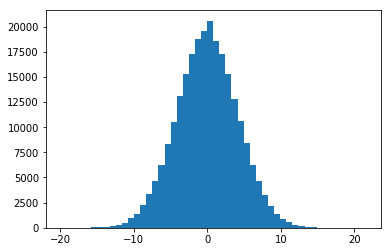

In [22]:
errors = diff.flatten()
plt.hist(errors, bins=50);

We can just use numpy to calc the required metrics on the diff to the reference image

In [23]:
def get_error_stats(errors):
    """
    Calculate the errors stats as required.
    """
    stats = {}
    stats['mean_error'] = np.mean(errors)
    stats['std_dev_errors'] = np.std(errors)
    stats['rmse_errors'] = np.sqrt(np.mean(np.power(errors, 2)))
    return stats

In [24]:
get_error_stats(errors)

{'mean_error': -0.015975451,
 'std_dev_errors': 4.139716,
 'rmse_errors': 4.1397476}

## Fully process an image
Lets make a final helper to wrap up the processing for a single image

In [25]:
def process_dem(file_path):
    """
    Convenience to perform processing on a single dem.
    """
    reprojected_file = reproject_file(file_path)
    ref_dem_path = 'Reference_DEM.tif'
    diff = compare_dems(reprojected_file, ref_dem_path)
    errors = diff.flatten()
    return get_error_stats(errors)

Test on a good image

In [26]:
process_dem(df.loc['58478']['file_path'])

58478_wgs84.tif


{'mean_error': -0.015975451,
 'std_dev_errors': 4.139716,
 'rmse_errors': 4.1397476}

Now its simple to create our report

In [27]:
report = []
error_files = []
for dem in supplier_DEMs:
    stats = process_dem(dem)
    stats['file_id'] = get_id(dem)
    report.append(stats)

58478_wgs84.tif
27441_wgs84.tif
51298_wgs84.tif
30512_wgs84.tif
15157_wgs84.tif
70269_wgs84.tif
29268_wgs84.tif
40999_wgs84.tif
48493_wgs84.tif
81645_wgs84.tif
39146_wgs84.tif
17899_wgs84.tif
34893_wgs84.tif
78497_wgs84.tif
74861_wgs84.tif
79821_wgs84.tif
11544_wgs84.tif
30628_wgs84.tif
35832_wgs84.tif
81951_wgs84.tif
87924_wgs84.tif
77394_wgs84.tif
56986_wgs84.tif
96779_wgs84.tif
75192_wgs84.tif
18756_wgs84.tif
95664_wgs84.tif
58789_wgs84.tif
14959_wgs84.tif
84379_wgs84.tif
58944_wgs84.tif
41185_wgs84.tif
33659_wgs84.tif
42275_wgs84.tif
85716_wgs84.tif
44851_wgs84.tif
85943_wgs84.tif
23820_wgs84.tif
23215_wgs84.tif
11846_wgs84.tif
61812_wgs84.tif
02341_wgs84.tif
45036_wgs84.tif
73963_wgs84.tif
92547_wgs84.tif
67915_wgs84.tif
03288_wgs84.tif
75120_wgs84.tif
89576_wgs84.tif
80220_wgs84.tif


In [28]:
report_df = pd.DataFrame.from_records(report, index='file_id')

In [29]:
report_df.head()

,mean_error,rmse_errors,std_dev_errors
file_id,,,
58478,-0.015975,4.139748,4.139716
27441,-0.005986,0.891497,0.891477
51298,0.000686,5.892635,5.892634
30512,0.000000,0.000000,0.000000
15157,-0.001545,1.315194,1.315193


Lets append our original table

In [30]:
final_df = df.join(report_df)

In [31]:
final_df.head()

,count,crs,driver,dtype,file_path,height,max,mean,median,min,nodata,std,transform,width,mean_error,rmse_errors,std_dev_errors
file_id,,,,,,,,,,,,,,,,,
58478,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,500,406.388062,367.627136,368.764893,329.632263,-32767.0,11.250950,"(2.0, 0.0, 481176.776338, 0.0, -2.0, 3890634.7...",500,-0.015975,4.139748,4.139716
27441,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,500,388.714539,367.637177,369.045258,343.403351,-32767.0,10.475924,"(2.0, 0.0, 481176.776338, 0.0, -2.0, 3890634.7...",500,-0.005986,0.891497,0.891477
51298,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,500,409.500336,367.643585,368.615662,319.584595,-32767.0,12.019057,"(2.0, 0.0, 481176.776338, 0.0, -2.0, 3890634.7...",500,0.000686,5.892635,5.892634
30512,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,250,399.585114,367.623016,368.870422,333.904541,-32767.0,10.958225,"(4.0, 0.0, 481176.776338, 0.0, -4.0, 3890634.7...",250,0.000000,0.000000,0.000000
15157,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,500,394.203430,367.641998,368.974487,339.293427,-32767.0,10.495005,"(2.0, 0.0, 481176.776338, 0.0, -2.0, 3890634.7...",500,-0.001545,1.315194,1.315193


In [32]:
final_df.to_csv('final_report.csv')

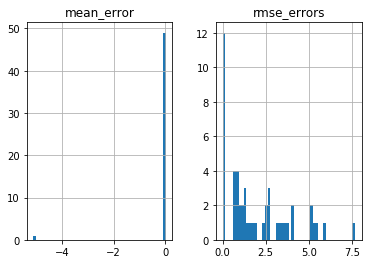

In [33]:
final_df[['mean_error', 'rmse_errors']].hist(bins=50);

The files which failed to process have `mean_error` == 0, lets put the failures in their own table

In [34]:
failures = final_df[final_df['mean_error'] == 0]
failures

,count,crs,driver,dtype,file_path,height,max,mean,median,min,nodata,std,transform,width,mean_error,rmse_errors,std_dev_errors
file_id,,,,,,,,,,,,,,,,,
30512,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,250,399.585114,367.623016,368.870422,333.904541,-3.276700e+04,10.958225,"(4.0, 0.0, 481176.776338, 0.0, -4.0, 3890634.7...",250,0.0,0.0,0.0
40999,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,250,387.990234,367.647308,369.015198,344.792175,-3.276700e+04,10.434720,"(4.0, 0.0, 481176.776338, 0.0, -4.0, 3890634.7...",250,0.0,0.0,0.0
39146,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,250,396.284058,367.586243,368.896973,338.130737,-3.276700e+04,10.668123,"(4.0, 0.0, 481176.776338, 0.0, -4.0, 3890634.7...",250,0.0,0.0,0.0
17899,1,+init=epsg:4326,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,450,386.559418,214.436569,368.859314,-32767.011719,-3.276700e+04,2247.767090,"(2.010036380255282e-05, 0.0, 44.793322779, 0.0...",547,0.0,0.0,0.0
78497,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,250,392.831451,362.506683,363.714905,327.381683,-3.276700e+04,11.000294,"(4.0, 0.0, 481176.776338, 0.0, -4.0, 3890634.7...",250,0.0,0.0,0.0
74861,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,250,402.364807,367.616730,368.651184,331.285614,-3.276700e+04,11.410122,"(4.0, 0.0, 481176.776338, 0.0, -4.0, 3890634.7...",250,0.0,0.0,0.0
11544,1,+init=epsg:4326,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,450,386.523346,214.416061,368.863800,-32767.009766,-3.276700e+04,2247.765869,"(2.0100363802565812e-05, 0.0, 44.79332278, 0.0...",547,0.0,0.0,0.0
95664,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,500,408.442902,387.647339,389.053528,364.004028,-3.402823e+38,10.440264,"(2.0, 0.0, 481176.77634, 0.0, -2.0, 3890634.70...",500,0.0,0.0,0.0
58944,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,250,391.005707,367.642242,368.934387,337.737915,-3.276700e+04,10.543052,"(4.0, 0.0, 481176.776338, 0.0, -4.0, 3890634.7...",250,0.0,0.0,0.0


In [35]:
failures.to_csv('failures_report.csv')

## Lets briefly investigate the successes

In [36]:
successes_df = final_df[final_df['mean_error'] != 0]

In [37]:
successes_df.head().sort_values('mean_error', ascending=False)

,count,crs,driver,dtype,file_path,height,max,mean,median,min,nodata,std,transform,width,mean_error,rmse_errors,std_dev_errors
file_id,,,,,,,,,,,,,,,,,
51298,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,500,409.500336,367.643585,368.615662,319.584595,-32767.0,12.019057,"(2.0, 0.0, 481176.776338, 0.0, -2.0, 3890634.7...",500,0.000686,5.892635,5.892634
15157,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,500,394.203430,367.641998,368.974487,339.293427,-32767.0,10.495005,"(2.0, 0.0, 481176.776338, 0.0, -2.0, 3890634.7...",500,-0.001545,1.315194,1.315193
27441,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,500,388.714539,367.637177,369.045258,343.403351,-32767.0,10.475924,"(2.0, 0.0, 481176.776338, 0.0, -2.0, 3890634.7...",500,-0.005986,0.891497,0.891477
70269,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,500,388.648682,367.636719,369.048035,343.620239,-32767.0,10.474998,"(2.0, 0.0, 481176.776338, 0.0, -2.0, 3890634.7...",500,-0.006647,0.843657,0.843631
58478,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,500,406.388062,367.627136,368.764893,329.632263,-32767.0,11.250950,"(2.0, 0.0, 481176.776338, 0.0, -2.0, 3890634.7...",500,-0.015975,4.139748,4.139716


In [38]:
successes_df['mean_error'].describe()

count    38.000000
mean     -0.140094
std       0.830315
min      -5.123430
25%      -0.009263
50%      -0.005773
75%      -0.002470
max       0.023172
Name: mean_error, dtype: float64

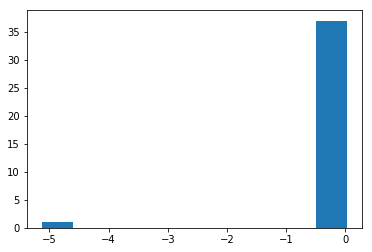

In [39]:
plt.hist(successes_df['mean_error']);

Most of the data is around the mean, but there is clearly one outlier

In [40]:
successes_df[successes_df['mean_error'] < -2 ] 

,count,crs,driver,dtype,file_path,height,max,mean,median,min,nodata,std,transform,width,mean_error,rmse_errors,std_dev_errors
file_id,,,,,,,,,,,,,,,,,
81645,1,+init=epsg:32638,GTiff,float32,/Users/robincole/Documents/Data/EODS_Test_Data...,500,402.060425,362.506775,363.529999,320.598083,-32767.0,11.952258,"(2.0, 0.0, 481176.776338, 0.0, -2.0, 3890634.7...",500,-5.12343,7.691947,5.737293


TypeError: Image data cannot be converted to float

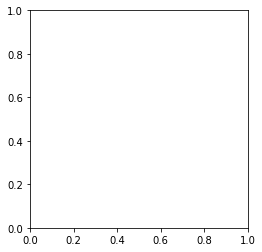

In [44]:
show(successes_df.loc['81645']['file_path'])

We should investigate that image

In [42]:
successes_df['rmse_errors'].describe()

count    38.000000
mean      2.550012
std       1.788355
min       0.720815
25%       1.047047
50%       2.101076
75%       3.583192
max       7.691947
Name: rmse_errors, dtype: float64

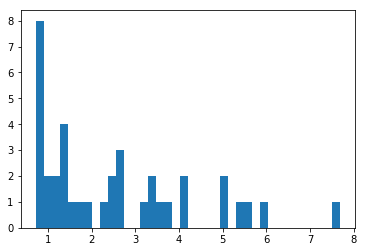

In [43]:
plt.hist(successes_df['rmse_errors'], bins=38);

`rmse_errors` are approximately normally distributed